In [1]:
import sys
print("Python executable:", sys.executable)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import backtesting as bt
import yfinance as yf
from sklearn.linear_model import LinearRegression
import sqlite3

print("All imports succeeded.")


Python executable: c:\Users\caysh\OneDrive\Documents\Projects\FirstProj\.venv\Scripts\python.exe


c:\Users\caysh\OneDrive\Documents\Projects\FirstProj\.venv\lib\site-packages\backtesting\_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

All imports succeeded.


In [ ]:
# Function to create SQLite database and prices table
# Creates the database file 'portfolio.db' with a table 'prices' if it doesn't exist
# Each row in c.execute corresponds to a column in the yfinance table
def create_database():
    conn = sqlite3.connect('portfolio.db')
    c = conn.cursor()
    c.execute('''
              CREATE TABLE IF NOT EXISTS prices
                 (Date TEXT,
              ticker TEXT,
              Open REAL,
              High REAL,
              Low REAL,
              Close REAL,
              Volume INTEGER)
              ''')
    conn.commit()
    conn.close()    

In [ ]:
# Function to insert price data into portfolio.db that we created above
def insert_price_data(ticker, db_name="portfolio.db"):
    conn = sqlite3.connect(db_name)

    df = yf.download(ticker, period="5y").reset_index()

    # Flatten MultiIndex columns if present, but KEEP original capitalization
    df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]

    df['ticker'] = ticker

    df[['Date', 'ticker', 'Open', 'High', 'Low', 'Close', 'Volume']].to_sql(
        'prices', conn, if_exists='append', index=False
    )

    conn.close()

insert_price_data("AAPL")

C:\Users\caysh\AppData\Local\Temp\ipykernel_9260\3988555142.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period="5y").reset_index()
[*********************100%***********************]  1 of 1 completed


In [29]:
conn = sqlite3.connect("portfolio.db")
df_test = pd.read_sql("SELECT * FROM prices LIMIT 5;", conn)
conn.close()

df_test

,Date,ticker,Open,High,Low,Close,Volume
0,2020-11-23 00:00:00,AAPL,114.069143,114.497465,110.730201,110.827545,127959300
1,2020-11-24 00:00:00,AAPL,110.885951,112.774443,109.600987,112.112495,113874200
2,2020-11-25 00:00:00,AAPL,112.482401,113.650540,112.112484,112.949654,76499200
3,2020-11-27 00:00:00,AAPL,113.475331,114.370905,113.134624,113.494797,46691300
4,2020-11-30 00:00:00,AAPL,113.864721,117.758530,113.708965,115.889503,169410200


In [30]:
def load_price_data(ticker, db_name="portfolio.db"):
    conn = sqlite3.connect(db_name)
    df = pd.read_sql(
        f"SELECT * FROM prices WHERE ticker='{ticker}' ORDER BY date;", conn,
        parse_dates=["date"]
    )
    conn.close()
    return df

In [33]:
df = load_price_data("AAPL")
df.head()

,Date,ticker,Open,High,Low,Close,Volume
0,2020-11-23 00:00:00,AAPL,114.069143,114.497465,110.730201,110.827545,127959300
1,2020-11-24 00:00:00,AAPL,110.885951,112.774443,109.600987,112.112495,113874200
2,2020-11-25 00:00:00,AAPL,112.482401,113.650540,112.112484,112.949654,76499200
3,2020-11-27 00:00:00,AAPL,113.475331,114.370905,113.134624,113.494797,46691300
4,2020-11-30 00:00:00,AAPL,113.864721,117.758530,113.708965,115.889503,169410200


In [34]:
df['Return'] = df['Close'].pct_change()
df['Log Return'] = np.log(df['Close'] / df['Close'].shift(1))
df['Rolling_Vol'] = df['Log Return'].rolling(window=21).std() * np.sqrt(252)    

array([<Axes: >, <Axes: >], dtype=object)

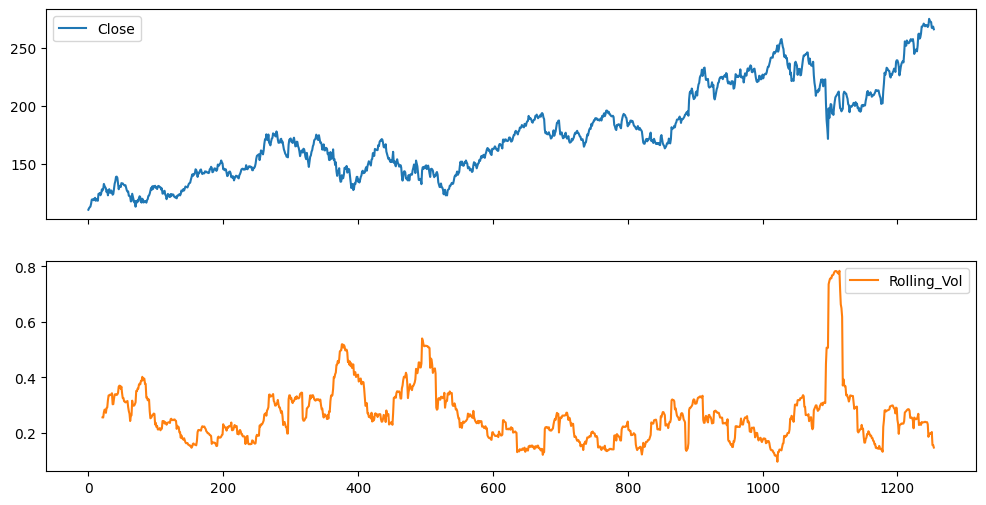

In [36]:
df[['Close', 'Rolling_Vol']].plot(subplots=True, figsize=(12,6))
